# Neural Networks: Multilayer Perceptron (MLP) with PyTorch

- Neural Networks can have a massice number of parameters, with dozens of layers, meaning the model will have a lot of work to learn and optimize everything!
- Well, this is exactly Deep Learning 
- To help this networks building, Pytorch has a module called `nn`


In [4]:
import torch
from torchvision import datasets, transforms

# for better image plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# defining transforms for data normalization 
transform = transforms.Compose([transforms.ToTensor(),                  # setting PIL image --> pytorch tensor
                                transforms.Normalize((0.5,), (0.5,))])   # B/W only have 2 channels

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])   # normalize only 2 channels bc it's a B&W picture

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### We created a  `trainloader` and now we'll pass an _iterator_ `iter(trainloader)`:

```python
for image, label in trainloader:
    ## do things with images and labels
```

### Note that the batch_size here is 64, so let's check it out the first batch:
- `images` is a vector with size `(64, 1, 28, 28)`, that means, 64 images / batch, $1$ color per channel  (RBG it woulb be 3 channels), the the size of the images are 28x28 pixels.

In [8]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


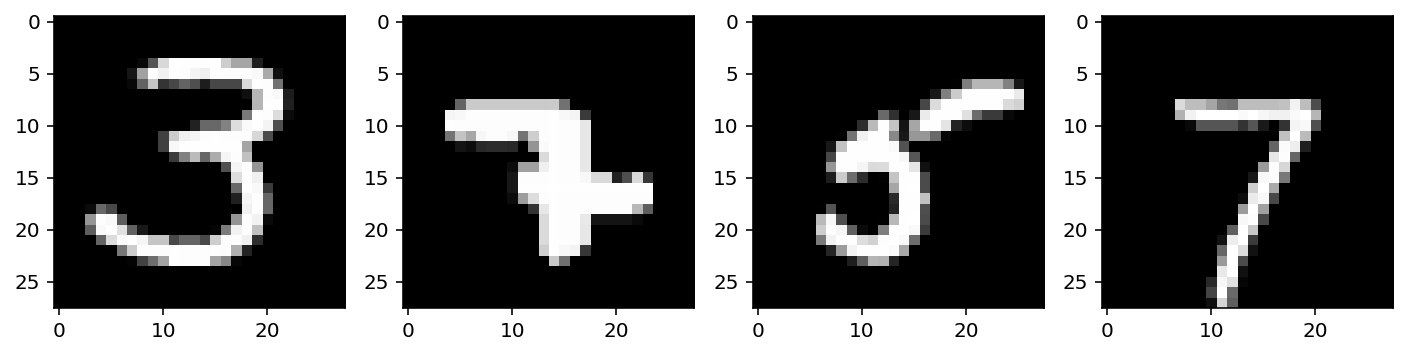

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(12,4))
for i in range(4):
    ax[i].imshow(images[i].numpy().squeeze(), cmap='Greys_r');

## To understand the theory behind neural networks, I'll first build one using matrix multiplication
- After, I'll use the module `nn`

## MLP layers:
- are called *fully-connected* or *dense*
- all units from one layer are connected to all units from the next layer
- The input from each layer must be a 1D vector
- So, in the MNIST example here, the 28x28 px images will be converted to tensors of 784 units
- Thus, the tensor: `(64, 1, 28, 28)` will be converted to: `(64, 784)`
- This procedure is called *flattening* ( 2Dtensor -------> 1Dtensor )

## At this example, we have the **input**, one **hidden** and the **output** layers:

In [16]:
## activation function
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

# Flattening: keeps the first dimension (64), which is the batch_size and transforms the other dimension in one
inputs =  images.view(images.shape[0],-1)

# defining the weights that connect the input layer to the hidden layer
W1 = torch.randn(inputs.shape[1] , 256)         ###  Note that the hidden layer has 256 neurons:

# defining the weights that connect the hidden layer to the output layer
W2 = torch.randn(256, 10)             ### Note that the output layer has 10 neurons (=classify 10 digits)

# defining the bias term: first fot the hidden layer and than for the output layer (same number of neurons)
B1 = torch.randn(256)
B2 = torch.randn(10)

# compute the hidden layer terms passing the activation function:
h = sigmoid(torch.mm(inputs,W1) + B1)        ### mm: matrix multiplication

# computes the network output:
out = torch.mm(h,W2) + B2                

## With those 10 outputs, we want to know which class does the image belong to
- Thus, we compute the probability associated with each class
- This probability is computed with the function **Softmax**, defined as:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

- This function _squeezes_ the output to values between 0 and 1
- Then, the value is normalized 
- The sum of the probabilities (of each class) is always going to be = 1

## Defining the Softmax functiona according to the equation above:
- dim = 1 : the sum is going through each class, not through each sample
- The softmax returns a tensor with 64x10, that means for each image (from the batch) the class which it belongs to

In [17]:
def softmax(x):
    """Defining the Softmax function."""
    return torch.exp(x)/torch.sum(torch.exp(x),dim = 1).view(-1,1)

In [18]:
# probabilities is the output of the softmax size: (64,10) 
probabilities = softmax(out)

print(probabilities.shape)

torch.Size([64, 10])


In [20]:
# Checking the sum of the all the probabilities for 10 classes == 1
print(probabilities.sum(dim=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building the network with `nn` pytorch
- creating a class called `Network` which inherits from `nn.module`
- parameters: 
- `nn.Linear`: Applies a linear transformation to the incoming data:
    - self.hidden : input is **28x28pixels** to **256** at the hidden layer
        - This module creates the **weights** and **bias** tensors
        - These new tensors will be used in `forward` method 
        - To check these tensors out we can:
            - Instantiate the network and pass `net.hidden.weight` and `net.hidden.bias`.
    
    - self.output : **256** from the hidden to **10** in output
    - sigmoid and softmax (again passing dim = 1): defining the activation and output functions  
- `Forward` method:
    - receives "x" and passes the tensor for each operation

In [22]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # linear transformation 784 from input layer to 256 at the hidden layer 
        self.hidden = nn.Linear(784, 256)
        # again, from hidden to output
        self.output = nn.Linear(256, 10)
        
        # Define Sigmoid and Softmax functions
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # the forward method passes the x tensor through each operation
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [23]:
# creating the network
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

## Creating the Network class in a much easier way

In [26]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = F.softmax(self.output(x), dim=1)
        return x

### Since [Helper](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py) is not working here, I copied the function `view_classify` from the original file:

In [34]:
from torch import nn, optim
from torch.autograd import Variable

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Ativation Function

- the only requirement for a function to be used as activation function, is to be **non-linear**!
- common activation functions:
    1)  Tanh (hyperbolic tang)
    2)  Sigmoid
    3)  ReLU (rectified linear unit)


- ReLU is almost always used as activation function for hidden layers

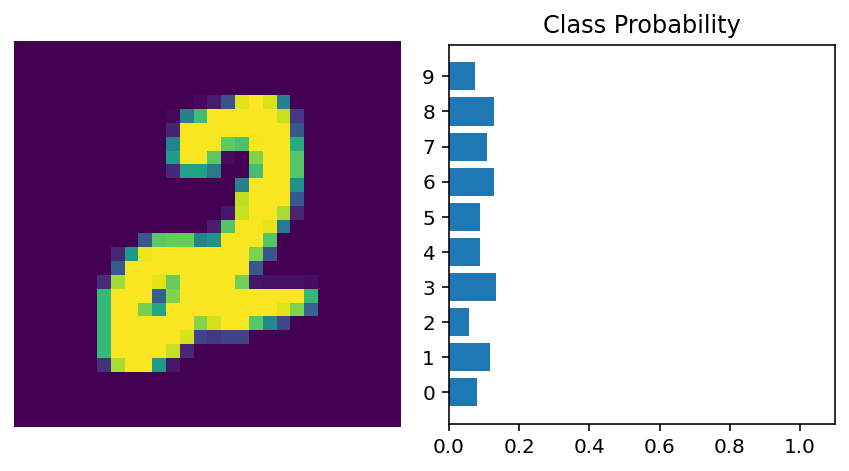

In [36]:
# obtaining some images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Reshaping this images to 1D vector 
#    New size: (batch_size, color channels, pixels) 
images.resize_(64, 1, 784)
# OR images.resize_(images.shape[0], 1, 784) it takes the batch_size automatically

# Pass the forward method 
img_idx = 2
ps = model.forward(images[img_idx,:])

img = images[img_idx]
# View the image and the barplot of each class probability
view_classify(img.view(1, 28, 28), ps)

## As we can see here, our network doensn't know what digit is this, yet
- the network was initialized with random weights


### Using `nn.Sequential`
- the module [`nn.Sequential`](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential) helps to build simple networks, where the tensor goes through operations, passing from one to another sequentially
- We can use this module to build a similar network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


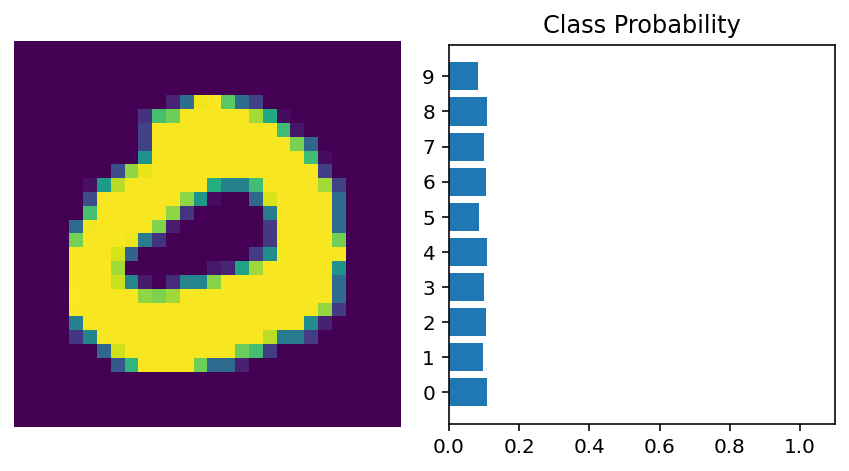

In [37]:
# Network Hyperparameters 
input_size = 784   
hidden_sizes = [128, 64]
output_size = 10

# feed-forward network           # input       # output
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward step from one sample through the network; showing the output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

### - Our network still doensn't know what digit is this. 
- That's why we have to train out network and teach it what each digit looks like

### MODEL:
- input units: 784
- hidden layers: 128
- Activation function: ReLU
- Another hidden layer: 64
- Activation function: ReLU
- Output layer: 10 (1 class per digit)
- Softmax


In [44]:
# loiking at the operations inside the model 
print('First operation:\033[31m', model[0])
print('\033[mSecond operation:\033[31m',model[1])
print('\033[mThird operation:\033[31m',model[2])
print('\033[m...')

First operation: Linear(in_features=784, out_features=128, bias=True)
Second operation: ReLU()
Third operation: Linear(in_features=128, out_features=64, bias=True)
...


In [47]:
print('\033[mWeights:\033[32m',model[0].weight)

Weights: Parameter containing:
tensor([[ 0.0251,  0.0067, -0.0042,  ...,  0.0280, -0.0041, -0.0180],
        [-0.0341,  0.0064,  0.0137,  ...,  0.0163, -0.0138,  0.0202],
        [ 0.0073, -0.0186, -0.0139,  ...,  0.0032, -0.0219, -0.0159],
        ...,
        [-0.0141,  0.0156, -0.0280,  ..., -0.0027, -0.0259, -0.0283],
        [-0.0331,  0.0233,  0.0147,  ..., -0.0048,  0.0350, -0.0075],
        [ 0.0019,  0.0118,  0.0022,  ..., -0.0286,  0.0274,  0.0244]],
       requires_grad=True)


In [48]:
print('\033[mBias:\033[32m',model[0].bias)

Bias: Parameter containing:
tensor([-0.0202, -0.0241,  0.0087,  0.0135, -0.0096, -0.0128, -0.0064,  0.0175,
        -0.0131,  0.0229,  0.0346, -0.0231,  0.0098, -0.0064,  0.0355, -0.0140,
        -0.0166, -0.0121, -0.0323, -0.0095,  0.0006, -0.0107,  0.0148, -0.0069,
        -0.0315, -0.0070, -0.0236,  0.0010,  0.0242, -0.0269, -0.0279, -0.0264,
        -0.0221,  0.0301,  0.0328, -0.0235,  0.0202,  0.0216,  0.0287,  0.0040,
         0.0289,  0.0344, -0.0059, -0.0302,  0.0149, -0.0195,  0.0066,  0.0048,
         0.0334, -0.0249, -0.0313, -0.0261, -0.0304,  0.0107,  0.0207,  0.0191,
         0.0295,  0.0300,  0.0268,  0.0122, -0.0223,  0.0256, -0.0231,  0.0296,
         0.0153, -0.0326,  0.0082, -0.0013, -0.0094, -0.0254,  0.0288, -0.0065,
        -0.0197, -0.0174,  0.0175, -0.0328, -0.0040,  0.0114, -0.0040,  0.0018,
        -0.0181,  0.0149, -0.0223,  0.0047, -0.0210,  0.0287,  0.0286, -0.0232,
        -0.0128, -0.0028,  0.0272,  0.0325, -0.0190, -0.0251, -0.0196, -0.0319,
         0.0

## Using `OrderedDict` 
- we can individually name each layer

In [49]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)